## ProT5 embeddings

In [ ]:
from katlas.feature import *
import pandas as pd
from katlas.data import *

In [ ]:
# pip install git+https://github.com/sky1ove/kdock.git

In [ ]:
from kdock.core.protein import *
import time

In [ ]:
from tqdm import tqdm
tqdm.pandas()

## Extract T5 embeddings

In [ ]:
df=Data.get_kinase_info()

In [ ]:
dd = df.sort_values('length',ascending=False).copy()

In [ ]:
dd.head()
# t5_feat = get_t5(dd.iloc[3:5],'human_uniprot_sequence')

,kinase,ID_coral,uniprot,gene,modi_group,group,family,subfamily_coral,subfamily,in_pspa_st,...,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
498,TTN,TTN,Q8WZ42,TTN,CAMK,CAMK,MLCK,NaN,MLCK,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,OBSCN,Obscn,Q5VST9,OBSCN,CAMK,CAMK,Trio,NaN,Trio,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326,OBSCN_b,Obscn_b,Q5VST9,OBSCN,CAMK,CAMK,Trio,NaN,Trio,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,DNAPK,DNAPK,P78527,PRKDC,Atypical,Atypical,PIKK,DNAPK,DNAPK,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,TRRAP,TRRAP,Q9Y4A5,TRRAP,Atypical,Atypical,PIKK,TRRAP,TRRAP,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We skip TTN (34350), OBSCN(7968), OBSCN_b(7968) as OOM and start with DNAPK(4128)

In [ ]:
skip_kinase = ['TTN','OBSCN','OBSCN_b']

df = df[~df.kinase.isin(skip_kinase)].copy()

In [ ]:
df['uniprot_gene'] = df.uniprot + '_' + df.gene

df = df.drop_duplicates('uniprot_gene')

df = df.set_index('uniprot_gene')

In [ ]:
# from transformers import T5Tokenizer, T5EncoderModel

# tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

#     # Load the model
# model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to('cuda')

In [ ]:
t5_feat = get_t5(df,'human_uniprot_sequence')

In [ ]:
# t5_feat.to_parquet('out/human_full_protein_t5.parquet')

## Hierarchical

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram
import matplotlib.pyplot as plt

In [ ]:
t5_feat = pd.read_parquet('out/human_full_protein_t5.parquet')

In [ ]:
Z = linkage(t5_feat, method='ward')

In [ ]:
from katlas.core import *

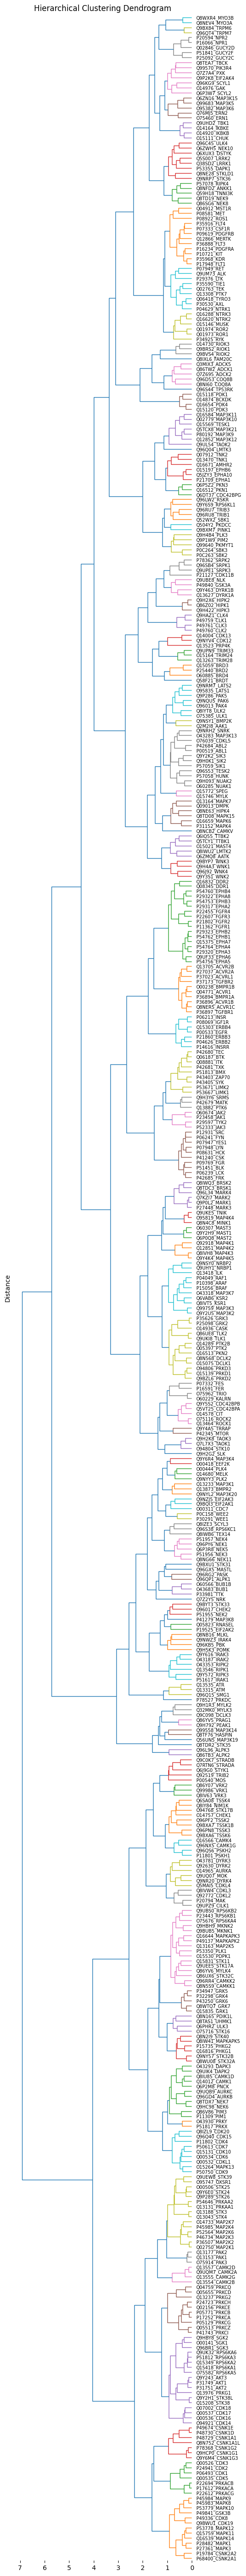

In [ ]:
plot_dendrogram(Z,labels=t5_feat.index,color_thr=1)
save_svg('full_protein_dendrogram.svg')

In [ ]:
from katlas.core import *

In [ ]:
pspa_df = pspa.set_index('kd_ID').iloc[:,5:]

In [ ]:
def get_dendrogram_labels(order_index, # iterable list of the dendrogram indexes
                          pssms, # df of flattened pssms with index as kd name
                          color_thr=0.15
                         ):
    
    labels = []
    for idx in order_index:
        if idx in pssms.index:
            flat_pssm =pssms.loc[idx]
            pssm_df = recover_pssm(flat_pssm)
            norm_pssm_df = clean_zero_normalize(pssm_df)
            seq = pssm_to_seq(norm_pssm_df, color_thr)
            labels.append(idx + ': ' + seq)
        else:
            labels.append(idx)

    return labels

In [ ]:
labels=get_dendrogram_labels(t5.index,pspa_df,0.15)

In [ ]:
pspa_df[pspa_df.index.str.contains('KC1A')]

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,...,4E,4s,4t,4y,0s,0t,0y,0S,0T,0Y
kd_ID,,,,,,,,,,,,,,,,,,,,,
P48729_KC1A_HUMAN_KD1,0.0843,0.0590,0.0664,0.0588,0.0590,0.0590,0.0459,0.0488,0.057,0.0530,...,0.0564,0.1808,0.1808,0.1458,1.0,0.1435,0.0,1.0,0.1435,0.0
Q8N752_KC1AL_HUMAN_KD1,0.0514,0.0528,0.0542,0.0535,0.0546,0.0546,0.0544,0.0645,0.064,0.0639,...,0.0512,0.0966,0.0966,0.1209,1.0,0.4354,0.0,1.0,0.4354,0.0


In [ ]:
# labels = [i+': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms.iterrows()]

In [ ]:
plot_dendrogram3(Z,labels =labels )

In [ ]:
pspa_df2 = pspa_df.reset_index()

In [ ]:
pspa_df2.shape

(362, 214)

In [ ]:
pspa_df.columns

Index(['-5P', '-5G', '-5A', '-5C', '-5S', '-5T', '-5V', '-5I', '-5L', '-5M',
       ...
       '4E', '4s', '4t', '4y', '0s', '0t', '0y', '0S', '0T', '0Y'],
      dtype='object', length=213)

In [ ]:
columns_to_fill = pspa_df.columns

In [ ]:
df = df.merge(pspa_df2,'left')

In [ ]:
for col in columns_to_fill:
    df[col] = df.groupby('kd_seq')[col].transform(lambda x: x.ffill().bfill())

In [ ]:
len(pspa_df2)

362

In [ ]:
df2 = df.dropna(subset='4E')

In [ ]:
df2 = df2.set_index('kd_ID')[columns_to_fill]

In [ ]:
labels=get_dendrogram_labels(t5.index,df2,0.15)

In [ ]:
plot_dendrogram3(Z,output='dendrogram_similarity_1.pdf',labels =labels )

## Kinase domain

In [ ]:
df = pd.read_excel('raw/uniprot_kd.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'raw/uniprot_kd.xlsx'

In [ ]:
df.shape

(5536, 27)

In [ ]:
t5feature = get_t5(df,'kd_seq')

  0%|          | 0/5536 [00:00<?, ?it/s]

In [ ]:
t5feature_df = t5feature.set_index(df.kd_ID)

In [ ]:
# t5feature_df.to_parquet('out/uniprot_kd_t5.parquet')

## Load

In [ ]:
import pandas as pd

In [ ]:
t5=pd.read_parquet('out/uniprot_kd_t5.parquet')

In [ ]:
human = t5.loc[t5.index.str.contains('HUMAN')]

In [ ]:
human

,T5_0,T5_1,T5_2,T5_3,T5_4,T5_5,T5_6,T5_7,T5_8,T5_9,...,T5_1014,T5_1015,T5_1016,T5_1017,T5_1018,T5_1019,T5_1020,T5_1021,T5_1022,T5_1023
kd_ID,,,,,,,,,,,,,,,,,,,,,
A4D2B8_PM2P1_HUMAN_KD1,0.036774,0.059082,0.017517,0.029770,-0.031342,0.051331,-0.036804,-0.007477,0.003513,0.023254,...,0.005329,-0.007664,-0.023956,-0.061340,0.055481,-0.052155,-0.057739,-0.063416,0.037384,-0.042938
A4QPH2_PI4P2_HUMAN_KD1,0.085022,0.115601,-0.003788,-0.025375,0.002710,0.014046,-0.027451,-0.091187,-0.025314,-0.008125,...,-0.009933,-0.020767,-0.030838,-0.020828,0.036560,-0.056000,-0.019379,0.061218,-0.001641,0.055908
O00141_SGK1_HUMAN_KD1,0.044617,0.130127,-0.013618,0.014923,-0.008316,-0.014488,-0.027954,-0.045044,0.008698,-0.031647,...,-0.034180,-0.009949,-0.016205,-0.006100,0.057068,-0.041412,-0.022461,-0.004608,0.008453,0.003035
O00238_BMR1B_HUMAN_KD1,0.048584,0.143311,0.049774,0.009216,-0.013748,0.034637,-0.025513,-0.067810,0.004253,-0.000382,...,-0.042328,-0.019745,-0.037445,-0.010078,0.058380,-0.034637,-0.032471,-0.003811,-0.033539,-0.025116
O00311_CDC7_HUMAN_KD1,0.037994,0.018890,-0.033600,0.005436,-0.018784,0.082947,-0.035309,-0.002960,0.068237,0.008904,...,-0.050690,-0.050323,-0.017853,-0.051605,0.019638,0.011986,-0.053955,0.011955,0.024643,0.030258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y616_IRAK3_HUMAN_KD1,-0.016159,0.030655,0.008446,0.023926,0.003010,0.025528,-0.027893,-0.068665,0.048035,-0.020081,...,0.000594,-0.020996,0.041138,-0.086670,0.060516,0.029602,-0.006458,-0.001279,0.013954,-0.011383
Q9Y6E0_STK24_HUMAN_KD1,0.083130,0.109009,0.007038,0.000793,0.000355,0.006264,-0.031525,-0.044250,-0.047546,-0.010468,...,-0.040649,-0.009003,-0.076111,-0.012901,0.069702,-0.057648,-0.023697,-0.003151,0.001767,-0.020844
Q9Y6M4_KC1G3_HUMAN_KD1,0.081421,0.142700,-0.008904,-0.010002,-0.019638,0.021576,-0.047394,-0.060516,-0.010567,-0.041534,...,-0.013542,0.002172,-0.053345,0.003716,0.061646,-0.072937,-0.019058,-0.049835,-0.028427,-0.005585
